In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import warnings
from pathlib import Path 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import lightgbm as lgb 
import xgboost as xgb 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

### 简单建模

In [2]:
# 节约内存方法
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
data = pd.read_csv('data/data_for_model.csv')
data = reduce_mem_usage(data)  # 节约n
logging.info(f"data shape: {data.shape}")
data.head()

Memory usage of dataframe is 416000128.00 MB
2021-01-15 20:10:54,651 INFO: data shape: (1000000, 52)
Memory usage after optimization is: 108034680.00 MB
Decreased by 74.0%


,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,...,n13,n14,issueDateDT,employmentTitle_cnts,employmentTitle_rank,postCode_cnts,postCode_rank,title_cnts,title_rank,sample
0,0,35008.0,5,19.515625,918.0000,E,E2,2.0,2,110000.0,...,0.0,2.0,2587,1121,1121,2075,2075,7006,7006,train
1,1,18000.0,5,18.484375,462.0000,D,D2,5.0,0,46000.0,...,0.0,2.0,1888,125,125,3789,3789,28,28,train
2,2,12000.0,5,16.984375,298.2500,D,D3,8.0,0,74000.0,...,0.0,4.0,3044,1,1,1754,1754,393334,393334,train
3,3,11000.0,3,7.261719,341.0000,A,A4,10.0,1,118000.0,...,0.0,1.0,2983,2,2,551,551,148211,148211,train
4,4,3000.0,3,12.992188,101.0625,C,C2,NaN,1,29000.0,...,0.0,4.0,3196,51149,51149,1722,1722,4731,4731,train


In [4]:
#训练数据/测试数据

features_to_drop = ['id','issueDate','isDefault', 'sample']

X_train = data.loc[data['sample'] == 'train', :].drop(features_to_drop, axis=1)
X_test = data.loc[data['sample'] == 'test', :].drop(features_to_drop, axis=1)
y_train = data.loc[data['sample'] == 'train', 'isDefault']

X_train.shape, X_test.shape, y_train.shape

((800000, 48), (200000, 48), (800000,))

In [5]:
# 画图函数
def plot_roc(fpr, tpr, roc_auc):
    """画出roc曲线图"""
    plt.figure(figsize=(8, 8))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.legend(loc='best')
    plt.title('ROC')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # 画出对角线
    plt.plot([0,1],[0,1],'r--')
    plt.show()


### 1.基于LGB的基准模型

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'metric': 'auc',
    'min_child_weight': 1e-3,
    'num_leaves': 31,
    'max_depth': -1,
    'reg_lambda': 0,
    'reg_alpha': 0,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 0,
    'seed': 2020,
    'nthread': 8,
    'silent': True,
    'verbose': -1,
}

# 使用训练集数据进行模型训练
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

# 预测并计算ROC等相关指标
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.724835
未调参前lightgbm单模型在验证集上的AUC：0.724834800861464


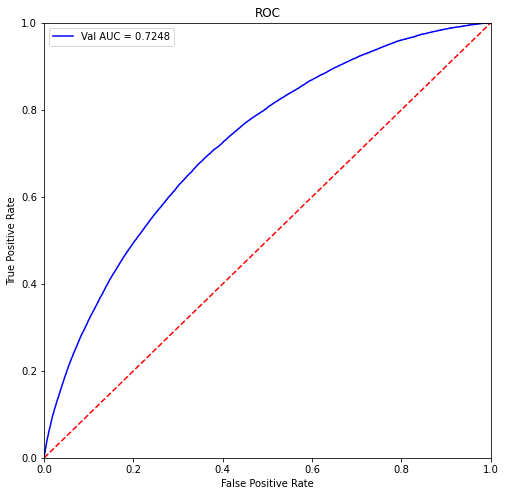

In [7]:
plot_roc(fpr, tpr, roc_auc)

### 2.基于LGB的5折交叉验证

In [8]:
from sklearn.model_selection import KFold

folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print(f'********************************** 第 {i+1} 折验证 **********************************')
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.1,
        'metric': 'auc',
        'min_child_weight': 1e-3,
        'num_leaves': 31,
        'max_depth': -1,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'feature_fraction': 1,
        'bagging_fraction': 1,
        'bagging_freq': 0,
        'seed': 2020,
        'nthread': 8,
        'silent': True,
        'verbose': -1,
    }
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

********************************** 第 1 折验证 **********************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.724985
[0.7249847978659988]
********************************** 第 2 折验证 **********************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.72235
[0.7249847978659988, 0.7223496809008884]
********************************** 第 3 折验证 **********************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.724774
[0.7249847978659988, 0.7223496809008884, 0.7247741972285904]
********************************** 第 4 折验证 **********************************
[LightGBM] [Warning] Unknown parameter: sile

### 3.贝叶斯调参
贝叶斯调参的主要思想是：给定优化的目标函数(广义的函数，只需指定输入和输出即可，无需知道内部结构以及数学性质)，通过不断地添加样本点来更新目标函数的后验分布(高斯过程,直到后验分布基本贴合于真实分布）。简单的说，就是考虑了上一次参数的信息，从而更好的调整当前的参数。

贝叶斯调参的步骤如下：

1.定义优化函数(rf_cv）  
2.建立模型  
3.定义待优化的参数  
4.得到优化结果，并返回要优化的分数指标


In [9]:
# 定义优化函数
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                )
    val = cross_val_score(model_lgb, X_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    return val 

In [10]:
%%time

from bayes_opt import BayesianOptimization

# 定义优化参数
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

# 开始优化
bayes_lgb.maximize(n_iter=10)

bsample_freq=0 will be ignored. Current value: bagging_freq=65
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=65, subsample_freq=0 will be ignored. Current value: bagging_freq=65
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] bagging_fraction is set=0.81, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=65, subsample_freq=0 will be ignored. Current value:

In [11]:
"""显示优化结果"""
bayes_lgb.max

{'target': 0.7261187627829302,
 'params': {'bagging_fraction': 0.9982062002606218,
  'bagging_freq': 78.7947659453105,
  'feature_fraction': 0.5729110883151318,
  'max_depth': 8.39578799302646,
  'min_child_weight': 9.27854523820222,
  'min_data_in_leaf': 18.36699190108219,
  'min_split_gain': 0.6890755237183666,
  'num_leaves': 148.2601577144868,
  'reg_alpha': 3.7951474175452518,
  'reg_lambda': 0.7086842196548493}}

### 基于最优参数的预测

In [14]:
from sklearn.model_selection import train_test_split

def lgb_model(X_train, y_train, X_test, y_test=None):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
           'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.01,
            'num_leaves': 14,
            'max_depth': 19,
            'min_data_in_leaf': 37,
            'min_child_weight':1.6,
            'bagging_fraction': 0.98,
            'feature_fraction': 0.69,
            'bagging_freq': 96,
            'reg_lambda': 9,
            'reg_alpha': 7,
            'min_split_gain': 0.4,
            'nthread': 8,
            'seed': 2020,
            'silent': True,
            'verbose': -1,
    }
    
    model = lgb.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=500, early_stopping_rounds=200)
    # 计算在验证集上的得分
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
    plot_roc(fpr, tpr, roc_auc)

    # 对测试集进行预测
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    return test_pred

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.727596	valid_1's auc: 0.724205
[1000]	training's auc: 0.737887	valid_1's auc: 0.727962
[1500]	training's auc: 0.744775	valid_1's auc: 0.729346
[2000]	training's auc: 0.750078	valid_1's auc: 0.730285
[2500]	training's auc: 0.754488	valid_1's auc: 0.730784
[3000]	training's auc: 0.758412	valid_1's auc: 0.730979
[3500]	training's auc: 0.761854	valid_1's auc: 0.73116
Early stopping, best iteration is:
[3782]	training's auc: 0.763583	valid_1's auc: 0.73121
调参后lightgbm单模型在验证集上的AUC：0.7312098346385935


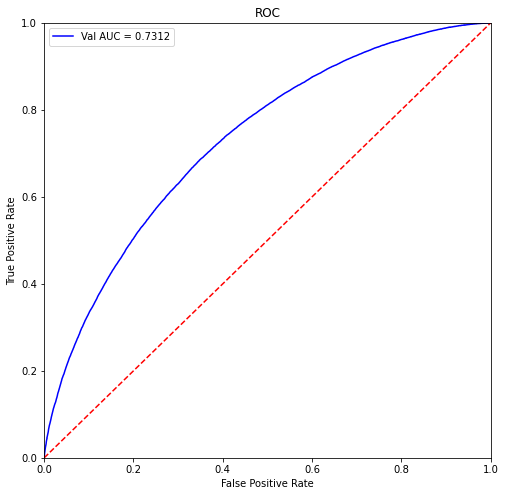

In [15]:
lgb_test_pred = lgb_model(X_train, y_train, X_test)

In [16]:
testA = data.loc[data['sample'] == 'test', :]
testA['isDefault'] = lgb_test_pred
testA[['id', 'isDefault']].to_csv('data/sub_lgb.csv', index=False)